## Flu and Variant-Specific Booster Uptake at the State Level

In this notebook, we look at the avaialability of flu clinics and compare it COVID variant-specific booster uptake within each of the U.S. 50 states. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
date_list = ["11/02/2022"]

state_list = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]

#### Cleaning and filtering COVID vaccine uptake dataset

In [3]:
booster_raw = pd.read_csv(
    "../../data/cdc/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv"
)
population_raw = pd.read_csv("../../data/cdc/state_population.csv")

In [4]:
booster_data = booster_raw.loc[
    :, ["Date", "Location", "Series_Complete_5Plus", "Bivalent_Booster_5Plus"]
]

In [5]:
booster_filter = booster_data.loc[
    booster_data.Date.isin(date_list) & booster_data.Location.isin(state_list)
].reset_index(drop=True)

In [6]:
booster_final = pd.DataFrame.merge(booster_filter, population_raw, on="Location")

In [8]:
booster_final["Elig_Pct"] = (
    booster_final.Bivalent_Booster_5Plus / booster_final.Series_Complete_5Plus
) * 100

#### Cleaning and filtering flu locations dataset

In [10]:
locations_raw = pd.read_csv(
    "../../data/cdc/Vaccines.gov__Flu_vaccinating_provider_locations.csv",
    low_memory=False,
)

In [11]:
col_names_clinics = {"provider_location_guid": "ID", "loc_admin_state": "Location"}

locations_raw.rename(columns=col_names_clinics, inplace=True)

In [12]:
locations_data = locations_raw.loc[:, ["ID", "Location"]]

In [13]:
locations_data = locations_data.drop_duplicates(subset=["ID"])

In [14]:
locations_count = locations_data.groupby("Location", as_index=False).agg(
    {"ID": "count"}
)

#### Cleaning and filtering political data

In [15]:
voting_raw = pd.read_csv("../../data/politics/1976-2020-president.csv")

In [16]:
year_list = [2020]
party_list = ["REPUBLICAN"]

In [17]:
col_names_voting = {
    "year": "Year",
    "state_po": "Location",
    "candidatevotes": "Candidate_Votes",
    "totalvotes": "Total_Votes",
    "party_simplified": "Party",
}

voting_raw.rename(columns=col_names_voting, inplace=True)

In [19]:
voting_data = voting_raw.loc[
    :, ["Year", "Location", "Candidate_Votes", "Total_Votes", "Party"]
]

In [20]:
voting_final = voting_data.loc[
    voting_data.Year.isin(year_list) & voting_data.Party.isin(party_list)
]

In [21]:
voting_final["Vote_Pct"] = (
    voting_final.Candidate_Votes / voting_final.Total_Votes
) * 100

/var/folders/z9/gdw88pxx7pnfg5bk987tzgqh0000gn/T/ipykernel_36860/470360614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voting_final["Vote_Pct"] = (voting_final.Candidate_Votes / voting_final.Total_Votes) * 100


#### Analysis

In [23]:
df_final = pd.DataFrame.merge(booster_final, locations_count, on="Location")

In [24]:
df_final["Clinics_100K"] = (df_final.ID / df_final.Population) * 100000

In [25]:
df_final_pol = pd.DataFrame.merge(df_final, voting_final, on="Location")

[Text(0.5, 1.0, 'Relationship between number of flu clinics and booster uptake')]

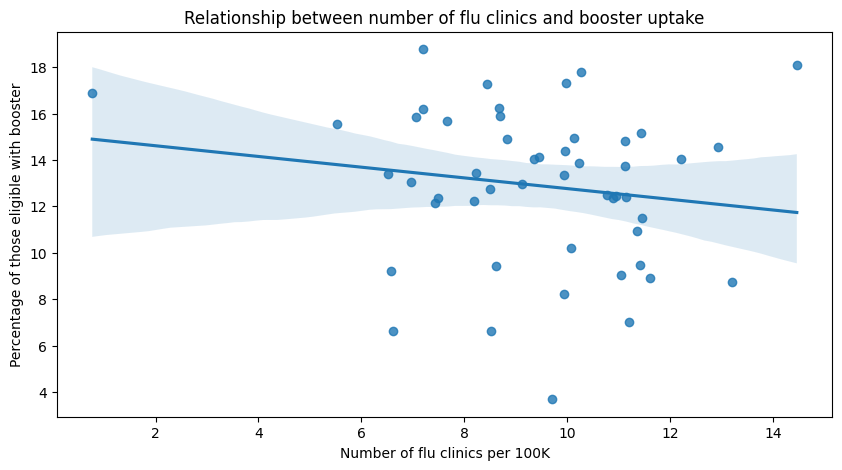

In [29]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.regplot(data=df_final_pol, x="Clinics_100K", y="Elig_Pct", y_partial="Vote_Pct")

ax.set(
    xlabel="Number of flu clinics per 100K",
    ylabel="Percentage of those eligible with booster",
)
ax.set(title="Relationship between number of flu clinics and booster uptake")